In [ ]:
from pandas import read_excel
from pandas import DataFrame
import pandas as pd
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from google.colab import drive

Accessing drive

In [ ]:
drive.mount('/content/drive')

Reading data from the excel file

In [ ]:
dfr = read_excel(r'/content/drive/My Drive/CMIE_PROJECT/panel.xlsx', sheet_name='mainpanel')

Dropping irrelevant variables

In [ ]:
dfr = dfr.drop(columns=['Total assets','Net fixed assets','Export / Sales (%)','IT/ITES & other professional services','Additions to computers and IT systems during the year','Gross software','Net profit margin','Net cash inflow or (outflow) from investing activities','Size','Total forex earnings / Total income (%)','Raw material imports / Raw material purchases (%)', 'Gross computers and IT systems'])

In [ ]:
df=dfr.copy()

Filling missing values, linearly

In [ ]:
def fill_nan_linearly(column):
    return column.interpolate(method='linear', limit_direction='both')

filled_df = df.groupby('Companies').apply(lambda group: group.apply(fill_nan_linearly, axis=0))
filled_df.reset_index(drop=True, inplace=True)

<ipython-input-8-db6b5264b618>:2: FutureWarning: Series.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  return column.interpolate(method='linear', limit_direction='both')


In [ ]:
df=filled_df.copy()

Mathematical manipulation to avoid explosion in mape value

In [ ]:
for i in df.columns:
  df.loc[df[i] == 0, i] = 0.1

<ipython-input-13-d2a5495eb679>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.1' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[df[i] == 0, i] = 0.1


Train Test Split

In [ ]:
train = df[df['Year'] < 2020]
test = df[df['Year'] >= 2021]

In [ ]:

X_train = train.drop(['Total income'], axis=1)
Y_train = DataFrame(train['Total income'])
X_test = test.drop(['Total income'], axis=1)
Y_test = DataFrame(test['Total income'])

Converting Data to supervised format

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    agg = concat(cols, axis=1)
    agg.columns = names

    if dropnan:
        agg.dropna(inplace=True)
    return agg


Reshaping the data

In [ ]:
def reshape_data(train,test):
    reframed_train = series_to_supervised(train, 1, 1)
    reframed_test = series_to_supervised(test, 1, 1)

    train= reframed_train.values
    test=reframed_test.values

    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]

    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train,y_test

Converting categorical labels into numeric values

In [ ]:
encoder = LabelEncoder()

train_data=pd.DataFrame()
train_data[X_train.columns]=X_train
train_data[Y_train.columns]=Y_train
train_data['Companies']= encoder.fit_transform(train_data['Companies'])

test_data=pd.DataFrame()
test_data[X_test.columns]=X_test
test_data[Y_test.columns]=Y_test
test_data['Companies']= encoder.fit_transform(test_data['Companies'])

In [ ]:
x_train,x_test,y_train,y_test=reshape_data(train_data,test_data)

Model

In [ ]:
model = Sequential()
model.add(LSTM(60, activation='relu',input_shape=(x_train.shape[1], x_train.shape[2])))

model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
history = model.fit(x_train, y_train, epochs=50, batch_size=50,  verbose=1, shuffle=False)

Epoch 1/50
802/802 [==============================] - 4s 3ms/step - loss: 1431.2318
Epoch 2/50
802/802 [==============================] - 2s 3ms/step - loss: 662.2263
Epoch 3/50
802/802 [==============================] - 2s 3ms/step - loss: 507.6883
Epoch 4/50
802/802 [==============================] - 2s 3ms/step - loss: 451.2021
Epoch 5/50
802/802 [==============================] - 4s 4ms/step - loss: 405.0074
Epoch 6/50
802/802 [==============================] - 3s 3ms/step - loss: 401.1196
Epoch 7/50
802/802 [==============================] - 2s 3ms/step - loss: 362.6795
Epoch 8/50
802/802 [==============================] - 2s 3ms/step - loss: 365.8473
Epoch 9/50
802/802 [==============================] - 2s 3ms/step - loss: 345.3854
Epoch 10/50
802/802 [==============================] - 2s 3ms/step - loss: 332.5894
Epoch 11/50
802/802 [==============================] - 4s 5ms/step - loss: 333.6026
Epoch 12/50
802/802 [==============================] - 2s 3ms/step - loss: 335.6139


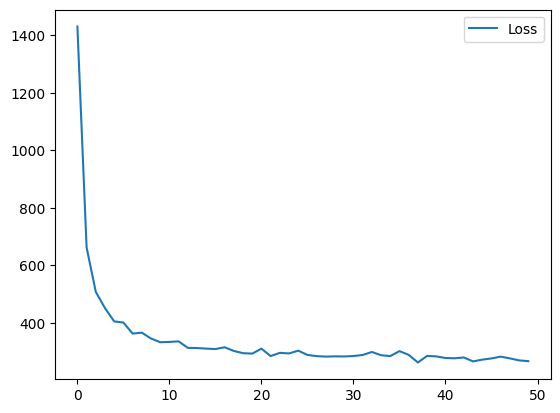

In [ ]:
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

In [ ]:
y_test_pre=model.predict(x_test)
y_train_pre=model.predict(x_train)

y_test_pre.shape,y_test.shape
y_train_pre.shape,y_train.shape

1253/1253 [==============================] - 3s 2ms/step


((40089, 1), (40089,))

In [ ]:
y_dat_pred=list(y_test_pre)+list(y_train_pre)
y_dat_act=list(y_test)+list(y_train)
year_dat=list(test_data['Year'])[1:]+list(train_data['Year'])[1:]

In [ ]:
pa=pd.DataFrame()
pa['Prediction']=[i[0] for i in y_dat_pred]
pa['Year']=year_dat
pa['Actual Values']=y_dat_act
pa.head()

,Prediction,Year,Actual Values
0,4419.878418,2021.0,4379.6
1,5257.450195,2022.0,5229.5
2,6078.783691,2023.0,6044.2
3,1138.969849,2020.0,1116.2
4,1269.174072,2021.0,1229.1


In [ ]:
pa.groupby('Year')['Prediction'].sum()

Year
2010.0    25021092.0
2011.0    25540144.0
2012.0    28806486.0
2013.0    32404152.0
2014.0    36143764.0
2015.0    39406340.0
2016.0    41832272.0
2017.0    45636184.0
2018.0    49043204.0
2019.0    55552340.0
2020.0    55631784.0
2021.0    55221980.0
2022.0    68746136.0
2023.0    80198456.0
Name: Prediction, dtype: float32

In [ ]:
pa.groupby('Year')['Actual Values'].sum()

Year
2010.0    2.534904e+07
2011.0    2.555476e+07
2012.0    2.860712e+07
2013.0    3.207748e+07
2014.0    3.613649e+07
2015.0    3.914672e+07
2016.0    4.172200e+07
2017.0    4.538526e+07
2018.0    4.881630e+07
2019.0    5.521588e+07
2020.0    5.557216e+07
2021.0    5.529990e+07
2022.0    6.857170e+07
2023.0    7.971540e+07
Name: Actual Values, dtype: float64

In [ ]:
from sklearn.metrics import mean_squared_error
def RMSE(actual,prediction):
    rmse = np.sqrt(mean_squared_error(actual,prediction))
    return rmse

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
def MAPE(actual,prediction):
    rmse = np.sqrt(mean_absolute_percentage_error(actual,prediction))
    return rmse

In [ ]:
from sklearn.metrics import r2_score
def R2(actual,prediction):
    r2= np.sqrt(r2_score(actual,prediction))
    return r2

In [ ]:
from sklearn.metrics import mean_absolute_error
def MAE(actual,prediction):
    mae= np.sqrt(mean_absolute_error(actual,prediction))
    return mae

RMSE of test

In [ ]:
print(RMSE(y_test,[i[0] for i in y_test_pre]))

3046.1343141859097


RMSE of train

In [ ]:
print(RMSE(y_train,[i[0] for i in y_train_pre]))

2091.0691118689347


Mape of test

In [ ]:
print(MAPE(y_test,[i[0] for i in y_test_pre]))

0.8727830148926595


Mape of train

In [ ]:
print(MAPE(y_train,[i[0] for i in y_train_pre]))

4.8336999264217


R2 of test

In [ ]:
print(R2(y_test,[i[0] for i in y_test_pre]))

0.9990274606967601


R2 of train

In [ ]:
print(R2(y_train,[i[0] for i in y_train_pre]))

0.9987540388209241


MAE of test

In [ ]:
print(MAE(y_test,[i[0] for i in y_test_pre]))

18.5979948704376


MAE of train

In [ ]:
print(MAE(y_train,[i[0] for i in y_train_pre]))

15.053460204716687


PLOT

In [ ]:

grouped_data = pa.groupby('Year').agg({'Prediction': 'sum', 'Actual Values': 'sum'}).reset_index()

trace_pred = go.Scatter(x=grouped_data['Year'], y=grouped_data['Prediction'], mode='lines', name='Prediction', line=dict(color='red'))
trace_actual = go.Scatter(x=grouped_data['Year'], y=grouped_data['Actual Values'], mode='lines', name='Actual Values', line=dict(color='blue'))

fig = go.Figure([trace_pred, trace_actual])
fig.update_layout(
    title='LSTM',
    xaxis=dict(title='Year', tickfont=dict(size=14)),
    yaxis=dict(title='Total Income (in Million Rs.)', tickfont=dict(size=14)),
    legend=dict(font=dict(size=14))
)

fig.show()
